In [119]:
import sys
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch

path = os.path.join('..', '/Users/dylandissanayake/Desktop/DPhil/Comp Disc/Repositories/TB-PNCA-GNN') if "SSH_CONNECTION" not in os.environ else os.path.join('..', '/mnt/alphafold-volume-1/dylan2/repos/tb-pnca-gnn')
if path not in sys.path:
    sys.path.append(os.path.abspath(path))

from src import evaluation

import pickle as pkl

### Reproduce bootstrapping from Carter et al

Same sampling method - each of the 10 samples is the same as in Carter et al

- Get mutations/indexes of ds-test.npy for the samples
- Use the same sample for the bootstraps for evaluation

In [92]:
from sklearn.utils import resample

from statsmodels.stats.weightstats import ztest as ztest

In [93]:
# load the training dataset
X={}
Y={}
Z={}
X['train']={}
Y['train']={}
Z['train']={}
with open('../data/ds-train.npy', 'rb') as f:
    Y['train']['input'] = np.load(f)
    X['train']['input'] = np.load(f)
    Z['train']['input'] = np.load(f, allow_pickle=True)

# load the test dataset
X['test']={}
Y['test']={}
Z['test']={}
with open('../data/ds-test.npy', 'rb') as f:
    Y['test']['input'] = np.load(f)
    X['test']['input'] = np.load(f)
    Z['test']['input'] = np.load(f, allow_pickle=True)
    

In [94]:
number_of_bootstraps = 10

def bootstrap_model(features, labels, mutations):
    x={}
    y={}
    z = {}
    for i in range(number_of_bootstraps):
        x[i],y[i], z[i] = resample(features['test']['input'], labels['test']['input'], mutations['test']['input'], random_state=42+i)

    return x, y, z

In [95]:
x, y, z = bootstrap_model(X, Y, Z)

In [96]:
z

{0: array(['V128G', 'A46S', 'I52N', 'H57Q', 'H43Y', 'G17S', 'F58Y', 'A30P',
        'V128G', 'R176G', 'N11I', 'S88T', 'S59T', 'A46E', 'H82L', 'G108R',
        'Q122L', 'R123C', 'A20E', 'G78D', 'S88T', 'D86N', 'M175I', 'E144G',
        'D49G', 'I90S', 'A30P', 'R29C', 'D110N', 'L116P', 'Q10H', 'F13V',
        'A178D', 'G97D', 'I90S', 'H57Q', 'Q141E', 'Q141E', 'A38S', 'Q141E',
        'D129E', 'Q10P', 'A20S', 'V45L', 'Q122L', 'D129E', 'V139L', 'A30P',
        'A79S', 'L4F', 'P54T', 'H71D', 'Q10H', 'G75D', 'K48T', 'L172R',
        'E173K', 'A20E', 'E144G', 'G16S', 'A3V', 'G60D', 'I90S', 'A20T',
        'A143D', 'E127K', 'A38S', 'A36V', 'R123L', 'H57P', 'I90F', 'H82L',
        'H71D', 'G78D', 'I6F', 'C184Y', 'A79T', 'P62L', 'C184Y', 'E107Q',
        'G124A', 'D49E', 'I31N', 'Q141E', 'K48T', 'L182W', 'S32I', 'H57Q',
        'V7D', 'Q141E', 'L182M', 'Y103D', 'G60D', 'A20E', 'D110V', 'T168A',
        'I90S', 'V163M', 'V157A', 'N112Y', 'H57Q', 'Y95N', 'F50Y', 'Q10H',
        'D8G', 'L172R', 'S8

### Select bootstrapped samples from GCN dataset

In [97]:
with open('./datasets/normed_singletons_af_w_pza_graph_dict.pkl', 'rb') as f:
    
    data = pkl.load(f)

In [98]:
next(iter(data['test'].items()))[1]['metadata']

,phenotype_label,number_resistant_mutations,number_susceptible_mutations,allele,mutation
99,R,1,0,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,I90T


In [99]:
# map mutation to dictionary key

mut_map = {}

for k, v in data['test'].items():
    key = k
    value = v['metadata']['mutation'].values[0]
    mut_map[value] = key

mut_map

{'I90T': 'pnca_mut_99',
 'A161T': 'pnca_mut_3',
 'V7F': 'pnca_mut_188',
 'A39S': 'pnca_mut_15',
 'R123G': 'pnca_mut_142',
 'D86N': 'pnca_mut_38',
 'S104I': 'pnca_mut_150',
 'L116R': 'pnca_mut_104',
 'E91D': 'pnca_mut_53',
 'D8H': 'pnca_mut_41',
 'L35V': 'pnca_mut_116',
 'N149D': 'pnca_mut_129',
 'Y95N': 'pnca_mut_197',
 'V45L': 'pnca_mut_185',
 'H57Q': 'pnca_mut_86',
 'I31N': 'pnca_mut_94',
 'F81S': 'pnca_mut_61',
 'Q10H': 'pnca_mut_136',
 'L172Q': 'pnca_mut_109',
 'N112S': 'pnca_mut_124',
 'G23A': 'pnca_mut_73',
 'A46S': 'pnca_mut_18',
 'D49Y': 'pnca_mut_33',
 'V128G': 'pnca_mut_170',
 'D129E': 'pnca_mut_27',
 'D63N': 'pnca_mut_35',
 'T100A': 'pnca_mut_162',
 'A36V': 'pnca_mut_13',
 'R123L': 'pnca_mut_144',
 'T76S': 'pnca_mut_169',
 'S32R': 'pnca_mut_156',
 'K96T': 'pnca_mut_102',
 'F13V': 'pnca_mut_55',
 'E15G': 'pnca_mut_47',
 'L172R': 'pnca_mut_110',
 'G75V': 'pnca_mut_78',
 'A20E': 'pnca_mut_5',
 'G124D': 'pnca_mut_67',
 'N149H': 'pnca_mut_130',
 'F58I': 'pnca_mut_58',
 'M175L': '

In [100]:
bootstrapped_data = {}

for i in z:
    bootstrapped_data[i] = []
    for sample in z[i]:
        dict_sample = mut_map[sample]
        bootstrapped_data[i].append(data['test'][dict_sample])
        

In [101]:
# check bootstrapping matches

for i in z:
    for j,_ in enumerate(z[i]):
        assert z[i][j] == bootstrapped_data[i][j]['metadata']['mutation'].values[0]

### Evaluate GCN with bootstrapped sampling

In [102]:
bootstrapped_data[0][0]['graph'].dataset[0].x

tensor([[0.6130, 0.1149, 0.5740,  ..., 0.7359, 0.1325, 0.0000],
        [0.6756, 0.5621, 0.7676,  ..., 0.7359, 0.1325, 0.0000],
        [0.1699, 0.3540, 0.1084,  ..., 0.7359, 0.1325, 0.0000],
        ...,
        [0.4764, 0.0870, 0.3253,  ..., 0.7359, 0.1325, 0.0000],
        [0.2886, 0.3199, 0.3571,  ..., 0.7359, 0.1325, 0.0000],
        [0.1723, 0.3540, 0.2324,  ..., 0.7359, 0.1325, 0.0000]])

In [104]:
# correct graph for model cutoff and edges
cutoff_distance = 12
edge_weight_func = "exp"
edge_weight_lambda = 2

In [106]:
for b in tqdm(bootstrapped_data):
    for sample in bootstrapped_data[b]:
        graph = sample['graph']
        
        # reset graph attributes based on new cutoff distance
        graph.cutoff_distance = cutoff_distance
        
        # calc new edge index and edge weights
        edge_index, d_array = graph._get_protein_struct_edges(graph.nodes.center_of_mass(compound='residues'))
        edge_dists = graph._gen_edge_dists(edge_index, d_array)
        edge_attr = graph.calc_edge_weights(edge_weight_func, edge_dists, edge_weight_lambda)
        
        # normalise edge weights
        edge_attr = graph.process_edge_weights(edge_attr)
        
        # change edge index and edge weights for Data object
        sample['graph'].dataset[0].edge_index = edge_index
        sample['graph'].dataset[0].edge_attr = edge_attr

100%|██████████| 10/10 [09:43<00:00, 58.38s/it]


In [117]:
from torch_geometric.data import DataLoader

# create data loaders for each bootstrap sample
data_loaders = {}

for b in bootstrapped_data:

    loader = DataLoader([sample['graph'].dataset[0] for sample in bootstrapped_data[b]],
                          batch_size=256,
                          shuffle=False)
    
    data_loaders[b] = loader

/home/ubuntu/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [120]:
model = torch.load("saved_models/train-final-model/Run 2 - 997 epochs - 0.80198 Test F1")

/tmp/ipykernel_2419772/26383064.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("saved_models/train-final-model/Run 2 - 997 epochs - 0.80198 Test F1")

Bootstrap 0:


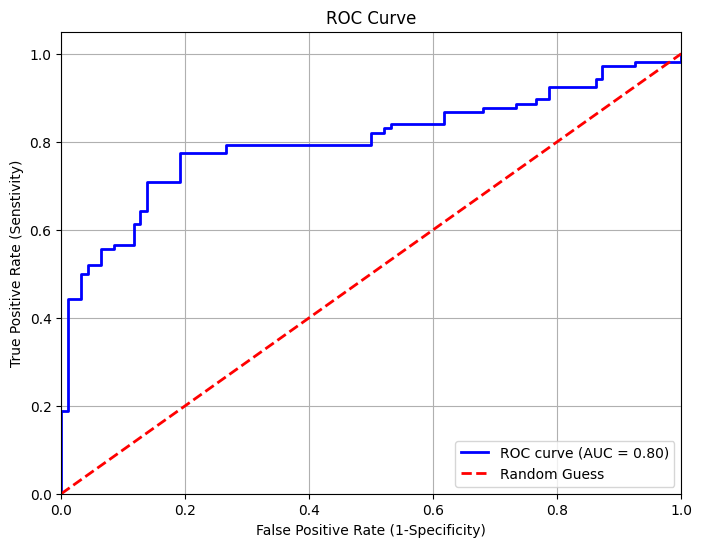

Number predicted resistant = 100. Number labeled R = 106
Number predicted susceptible = 100. Number labeled S = 94
Sensitivity: 0.77
Specificity: 0.81

 --- 

Bootstrap 1:


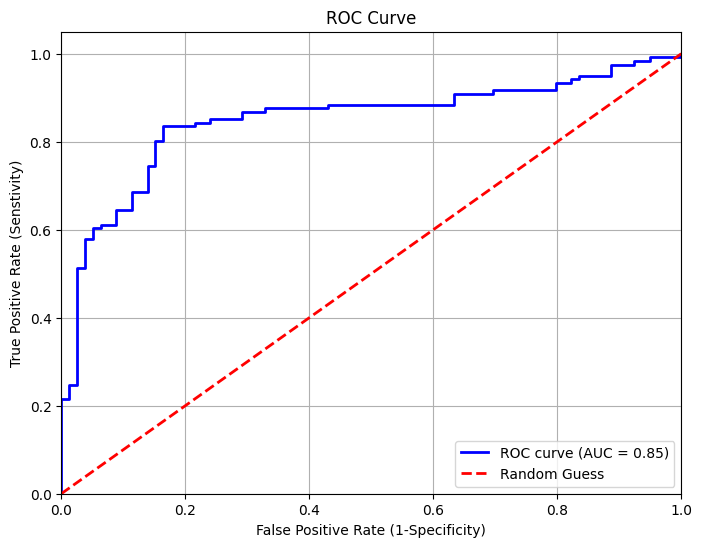

Number predicted resistant = 114. Number labeled R = 121
Number predicted susceptible = 86. Number labeled S = 79
Sensitivity: 0.83
Specificity: 0.84

 --- 

Bootstrap 2:


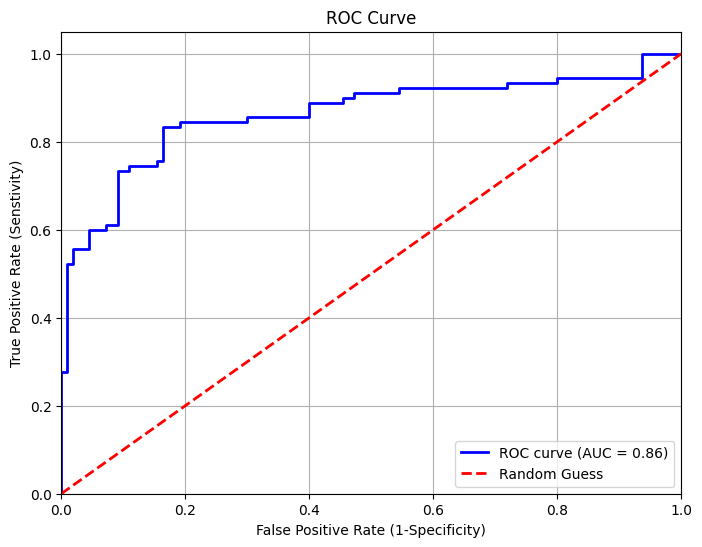

Number predicted resistant = 93. Number labeled R = 90
Number predicted susceptible = 107. Number labeled S = 110
Sensitivity: 0.83
Specificity: 0.84

 --- 

Bootstrap 3:


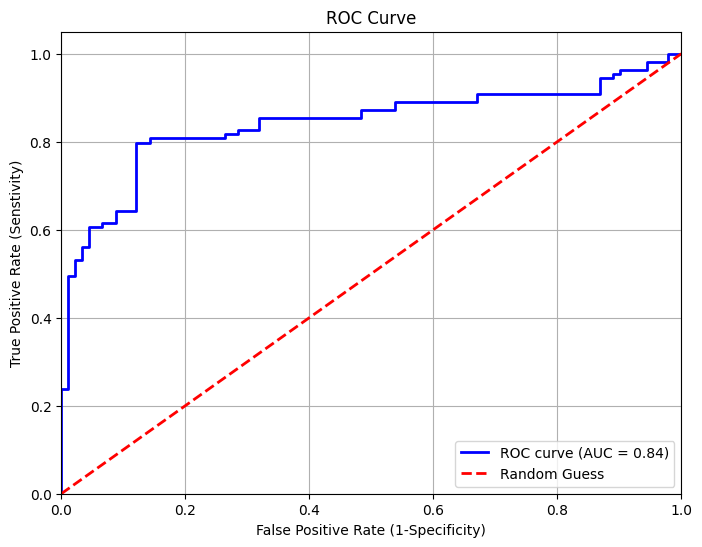

Number predicted resistant = 98. Number labeled R = 109
Number predicted susceptible = 102. Number labeled S = 91
Sensitivity: 0.80
Specificity: 0.88

 --- 

Bootstrap 4:


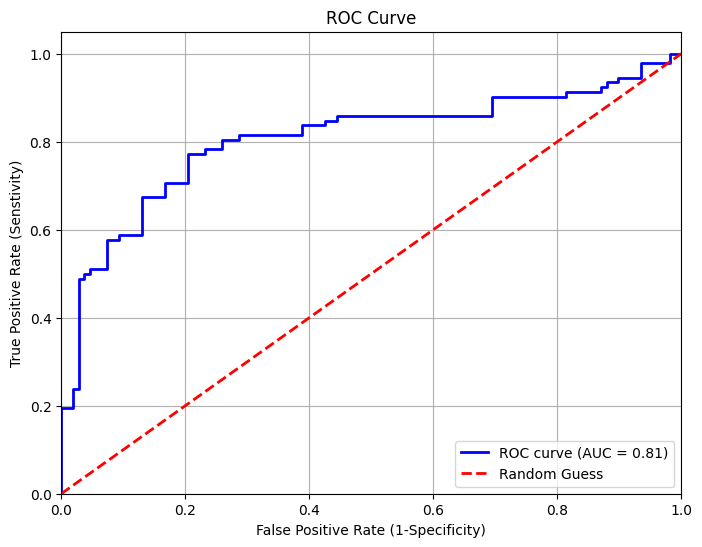

Number predicted resistant = 92. Number labeled R = 92
Number predicted susceptible = 108. Number labeled S = 108
Sensitivity: 0.76
Specificity: 0.80

 --- 

Bootstrap 5:


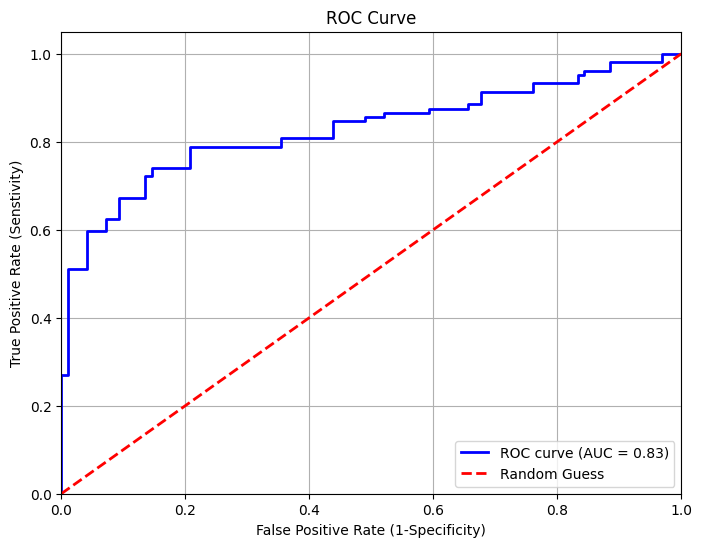

Number predicted resistant = 102. Number labeled R = 104
Number predicted susceptible = 98. Number labeled S = 96
Sensitivity: 0.79
Specificity: 0.79

 --- 

Bootstrap 6:


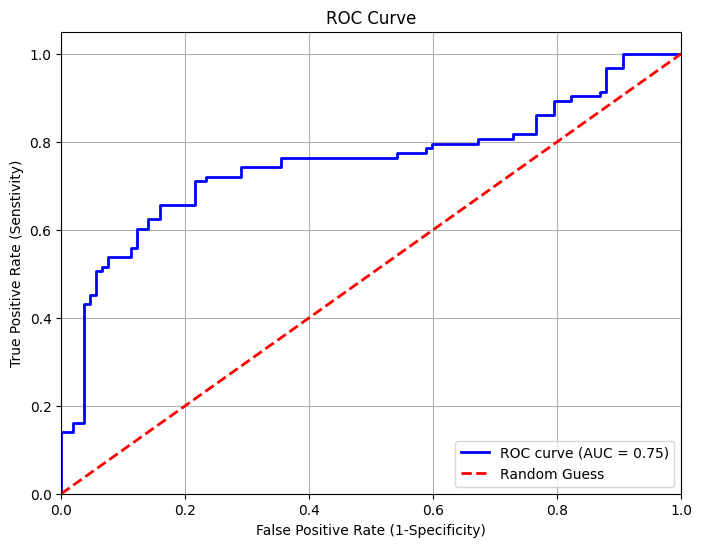

Number predicted resistant = 89. Number labeled R = 93
Number predicted susceptible = 111. Number labeled S = 107
Sensitivity: 0.71
Specificity: 0.79

 --- 

Bootstrap 7:


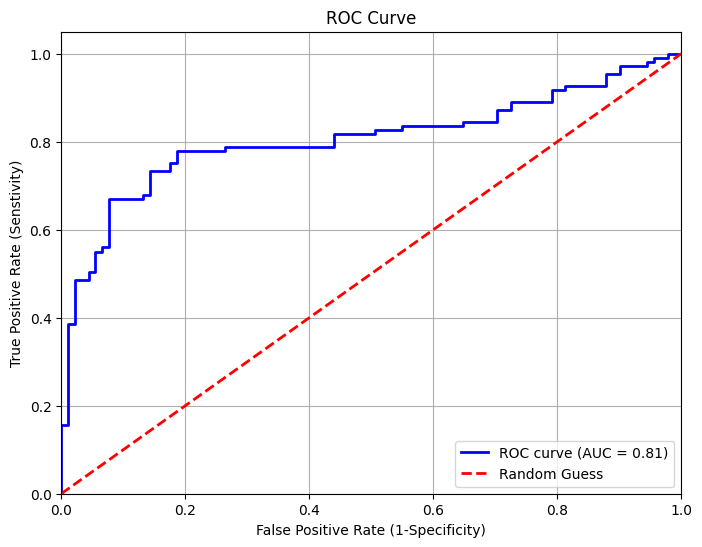

Number predicted resistant = 98. Number labeled R = 109
Number predicted susceptible = 102. Number labeled S = 91
Sensitivity: 0.75
Specificity: 0.82

 --- 

Bootstrap 8:


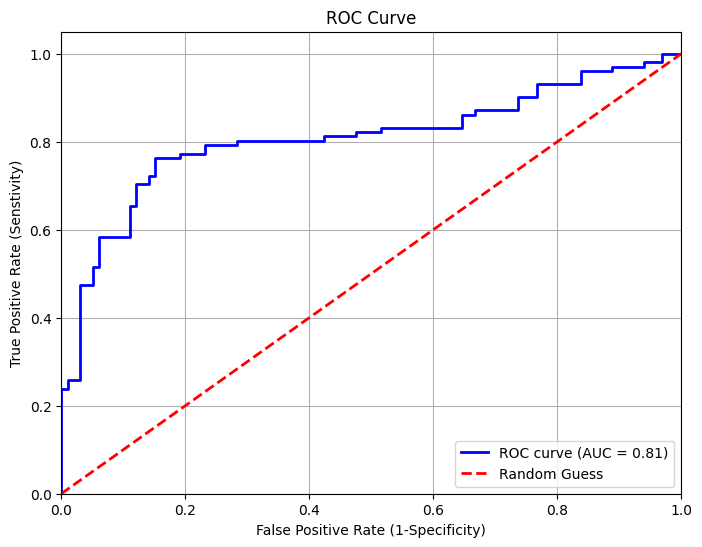

Number predicted resistant = 102. Number labeled R = 101
Number predicted susceptible = 98. Number labeled S = 99
Sensitivity: 0.78
Specificity: 0.77

 --- 

Bootstrap 9:


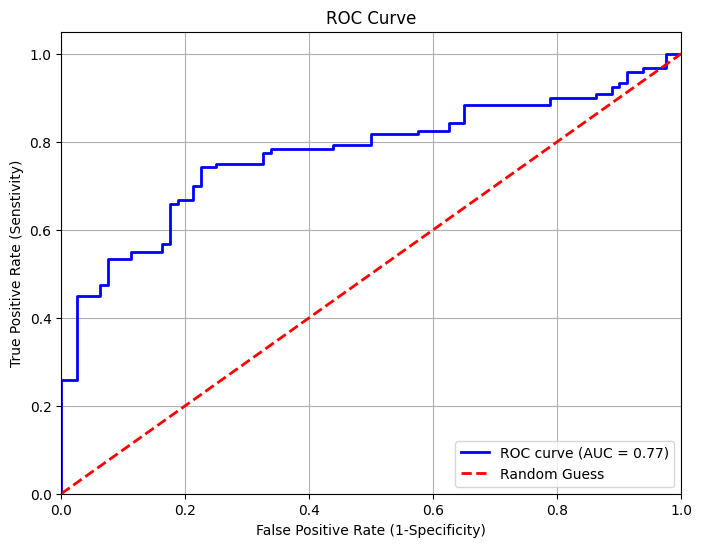

Number predicted resistant = 107. Number labeled R = 120
Number predicted susceptible = 93. Number labeled S = 80
Sensitivity: 0.74
Specificity: 0.78

 --- 



In [129]:
gcn_sens = []
gcn_spec = []

for b in data_loaders:
    print(f"Bootstrap {b}:")

    fpr, tpr, roc_auc = evaluation.calculate_roc(model, data_loaders[b])
    evaluation.plot_roc_curve(fpr, tpr, roc_auc)
    sens,spec = evaluation.calculate_sens_spec(model, data_loaders[b])
    gcn_sens.append(sens)
    gcn_spec.append(spec)
    
    print("\n --- \n")

In [ ]:
xb_sens = [
    0.80188679,
    0.86776860,
    0.78888889,
    0.83486239,
    0.78260870,
    0.78846154,
    0.77419355,
    0.81651376,
    0.85148515,
    0.75833333
]

xb_spec = [
    0.79787234,
    0.82278481,
    0.82727273,
    0.83516484,
    0.76851852,
    0.82291667,
    0.75700935,
    0.84615385,
    0.76767677,
    0.80000000
]

# XB F1 = 0.8019

In [133]:
from scipy.stats import ttest_rel

sens_t_stat, sens_p_val = ttest_rel(gcn_sens, xb_sens)
spec_t_stat, spec_p_val = ttest_rel(gcn_spec, xb_spec)

In [134]:
sens_p_val, spec_p_val

(0.025732115839425525, 0.5128355846211794)